In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from models.resnet import ResNet18
from data.data_engine import DataEngine
from config import ModelConfig
from train import train
from test import test
from utils import *

In [2]:
args = ModelConfig()
args.print_config()
print()
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': 'data/tiny-imagenet-200/new_test',
  'train_data_path': 'data/tiny-imagenet-200/new_train'}



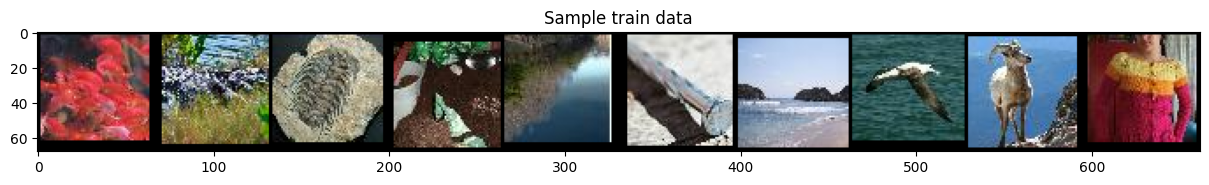

In [3]:
data = DataEngine(args)
data.show_samples()

In [4]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

EPOCH: 1 (LR: 0.002000)


L2_loss=465.361 Loss=7.69555 Batch_id=11 Accuracy=0.78:   2%|▏         | 12/602 [01:32<1:15:51,  7.71s/it]


KeyboardInterrupt: 